
![Py4Eng](img/logo.png)

# Data analysis: regression & curve fitting
## Yoav Ram

In [1]:
%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os.path
import zipfile
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import linregress
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette("Set1", 8, .75)
print('NumPy version:', np.__version__)
print('SciPy version:', scipy.__version__)
print('Pandas version:', pd.__version__)

NumPy version: 1.10.4
SciPy version: 0.17.0
Pandas version: 0.17.1


# Population growth dynamics

Our focus todays will be on modeling population growth. 
We will start with human populations and use data from the [World Bank](http://www.worldbank.org/) on the [population size of countries](http://data.worldbank.org/indicator/SP.POP.TOTL) around the world from 1960 until 2013.

## Data preparation

> In Data Science, 80% of time spent prepare data, 20% of time spent complain about need for prepare data.
    — [Big Data Borat](https://twitter.com/BigDataBorat/status/306596352991830016") (@BigDataBorat) February 27, 2013

So let's prepare the data from *scratch*.

Start by retrieving the data as a zip file (if not already downloaded). Follow the link to the World Bank page on [Population, total](http://data.worldbank.org/indicator/SP.POP.TOTL), click `DOWNLOAD DATA`, choose `CSV`, a zip file will be downloaded.  

Even better, click the `CSV` button with the right button and click `Copy link address` in the context menu. This link can be used to get the file directly from Python using `urllib`:

In [4]:
fname = r'../data/world_growth.zip'
if not os.path.exists(fname):
    urllib.request.urlretrieve('http://api.worldbank.org/v2/en/indicator/sp.pop.totl?downloadformat=csv', fname)

Open the file using the `zipfile` module and read it using _pandas_, skipping the first two rows and dropping the last two columns that have `NaN` values:

In [5]:
with zipfile.ZipFile(fname) as z:
    for f in z.filelist:
        print(f.filename)

Metadata_Indicator_bb36fae8-6c65-40c1-81bb-d814a595a46a_v2.csv
bb36fae8-6c65-40c1-81bb-d814a595a46a_v2.csv
Metadata_Country_bb36fae8-6c65-40c1-81bb-d814a595a46a_v2.csv
[Content_Types].xml


In [6]:
with zipfile.ZipFile(fname) as z:
    f = z.open('bb36fae8-6c65-40c1-81bb-d814a595a46a_v2.csv')
    df = pd.read_csv(f, skiprows=3)
    df.drop('2015', axis=1, inplace=True)
    df.drop('Unnamed: 60', axis=1, inplace=True)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208,55435,56226,56697,57029,57360,...,100031,100830,101218,101342,101416,101597,101936,102393,102921,103441
1,Andorra,AND,"Population, total",SP.POP.TOTL,13414,14376,15376,16410,17470,18551,...,81223,83373,84878,85616,85474,84419,82326,79316,75902,72786
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8994793,9164945,9343772,9531555,9728645,9935358,...,24399948,25183615,25877544,26528741,27207291,27962207,28809167,29726803,30682500,31627506
3,Angola,AGO,"Population, total",SP.POP.TOTL,5270844,5367287,5465905,5565808,5665701,5765025,...,17912942,18541467,19183907,19842251,20520103,21219954,21942296,22685632,23448202,24227524
4,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800,1711319,1762621,1814135,1864791,...,3011487,2992547,2970017,2947314,2927519,2913021,2904780,2900489,2897366,2894475


In [7]:
df.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
243,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5166311,5251663,5339285,5429501,5522690,5619170,...,20504385,21093973,21701105,22322699,22954226,23591972,24234940,24882792,25533217,26183676
244,South Africa,ZAF,"Population, total",SP.POP.TOTL,17396000,17949962,18459442,18936138,19390554,19832000,...,47349013,47991699,48656506,49344228,50055701,50791808,51553479,52341695,53157490,54001953
245,"Congo, Dem. Rep.",COD,"Population, total",SP.POP.TOTL,15248246,15637715,16041247,16461914,16903899,17369859,...,56089536,57926840,59834875,61809278,63845097,65938712,68087376,70291160,72552861,74877030
246,Zambia,ZMB,"Population, total",SP.POP.TOTL,3049586,3142848,3240664,3342894,3449266,3559687,...,12043591,12381509,12738676,13114579,13507849,13917439,14343526,14786581,15246086,15721343
247,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,3752390,3876638,4006262,4140804,4279561,4422132,...,12984418,13127942,13297798,13495462,13720997,13973897,14255592,14565482,14898092,15245855


We now want to **tidy our data** - transform the dataset to a **DataFrame** format:

> Tidy datasets are easy to manipulate, model and visualize, and have a specific structure: each variable is a column, each observation is a row, and each type of observational unit is a table - [Hadley Wickham (2014), _Tidy Data_, J. Stat. Soft.](http://www.jstatsoft.org/v59/i10)


This means that every row in the table has exactly one measurement population size with all the relevant variables: country name and year. Read more on [tidy data](http://www.jstatsoft.org/v59/i10).

We do this using  _pandas_ `melt` function: 

In [8]:
print(df.shape)
df = pd.melt(
    df, 
    id_vars=('Country Name','Country Code','Indicator Name', 'Indicator Code'), 
    var_name='Year', 
    value_name='Population'
)
print(df.shape)
df.head()

(248, 59)
(13640, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54208
1,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13414
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8994793
3,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5270844
4,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800


In [9]:
df.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
13635,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,2014,26183676
13636,South Africa,ZAF,"Population, total",SP.POP.TOTL,2014,54001953
13637,"Congo, Dem. Rep.",COD,"Population, total",SP.POP.TOTL,2014,74877030
13638,Zambia,ZMB,"Population, total",SP.POP.TOTL,2014,15721343
13639,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,2014,15245855


We get rid of rows that have `NA` values:

In [10]:
df.dropna(axis=0, inplace=True)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54208
1,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13414
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8994793
3,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5270844
4,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800


Note that for some reason the `Year` variable has a type `O` (object?) instead of `int`, so we change that:

In [11]:
print(df.Year.dtype, df.Population.dtype)
df.Year = df.Year.astype(int)
print(df.Year.dtype, df.Population.dtype)

object float64
int32 float64


## Data exploration with plots

Let's start with the three biggest population in the dataset - the entire world, China and India.
We will plot their population size over time:

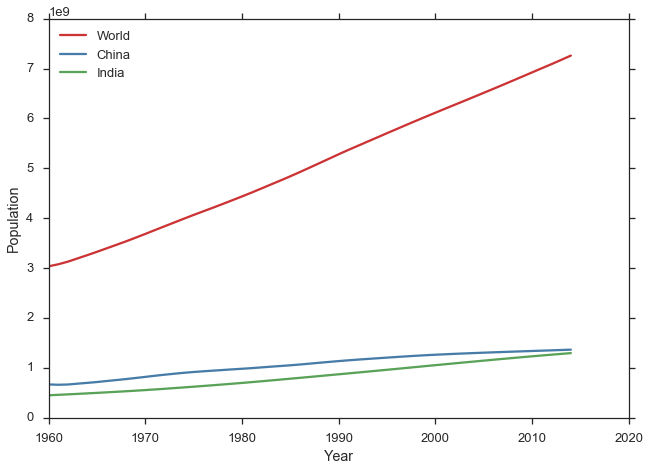

In [12]:
world = df[df['Country Name'] == 'World']
china = df[df['Country Name'] == 'China']
india = df[df['Country Name'] == 'India']

plt.plot(world.Year, world.Population, label='World')
plt.plot(china.Year, china.Population, label='China')
plt.plot(india.Year, india.Population, label='India')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Population');

Alternatively we can also plot using the `DataFrame.plot` method:

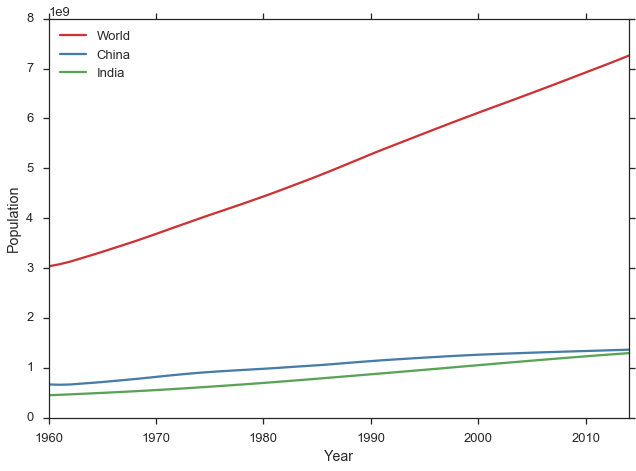

In [13]:
ax = world.plot('Year', 'Population')
china.plot('Year', 'Population', ax=ax)
india.plot('Year', 'Population', ax=ax)
ax.legend(['World', 'China', 'India'], loc='upper left')
ax.set_ylabel('Population');

## Exponential growth model

According to [Malthus](http://en.wikipedia.org/wiki/Thomas_Robert_Malthus) (but that was a long time ago, so don't count on it!), populations grow exponentialy ([how to solve this](https://www.youtube.com/watch?v=mhO9eL9Nuz0)):

$$
\frac{dN(t)}{dt} = r N(t) \Rightarrow \\
N(t) = N(0) e^{rt} \Rightarrow \\
\log{N(t)} = \log{N(0)} + rt
$$

where $N(t)$ is the population size at time $t$ and $r$ is the growth rate.

That means that that logarithm of the population should be a linear function of time.

Let's check if the world population growth is according to the exponential model. 
First define a new column for the log of the population size:

In [14]:
df['LogPopulation'] = np.log(df.Population)

![G8 flags](https://images1-focus-opensocial.googleusercontent.com/gadgets/proxy?url=http://environmentalgovernance.org/wp-content/uploads/2012/06/g8logo.jpg&container=focus&resize_w=150&refresh=2592000)

Let's concentrate on the [G8 countires](http://en.wikipedia.org/wiki/G8) (well, not exactly, but good enough for the purpose of this presentation):

In [15]:
G8_countries = ('France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States', 'Canada', 'European Union') # 'Russian Federation' was suspended in 2014
G8 = df[df['Country Name'].isin(G8_countries)]
G8.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population,LogPopulation
33,Canada,CAN,"Population, total",SP.POP.TOTL,1960,17909009,16.700814
52,Germany,DEU,"Population, total",SP.POP.TOTL,1960,72814900,18.103431
69,European Union,EUU,"Population, total",SP.POP.TOTL,1960,409498462,19.830444
73,France,FRA,"Population, total",SP.POP.TOTL,1960,46814237,17.661698
77,United Kingdom,GBR,"Population, total",SP.POP.TOTL,1960,52400000,17.774417


Here we do a _hack_ to sort the countires names based on the largest population in 2013 so that the next plot will have a legend that is ordered by country size. 

We start by splitting the data frame according to country name and extracting the max size for each country so that we will have a `pandas.Series` with the country as index and the max population size as the value. We then sort by the value (the population max size) and extract the index (the country). We will use this sorted list for ordering the colors in the next plot.

In [16]:
G8_countries = G8.groupby('Country Name').Population.max()
G8_countries.sort_values(ascending=False, inplace=True)
G8_countries = G8_countries.index
print(G8_countries.tolist())

['European Union', 'United States', 'Japan', 'Germany', 'France', 'United Kingdom', 'Italy', 'Canada']


We now plot the log of the population sizes. Note that only the first 3 arguments are neccessary and the rest are are just used to make a more aesthetic and professional looking plot.

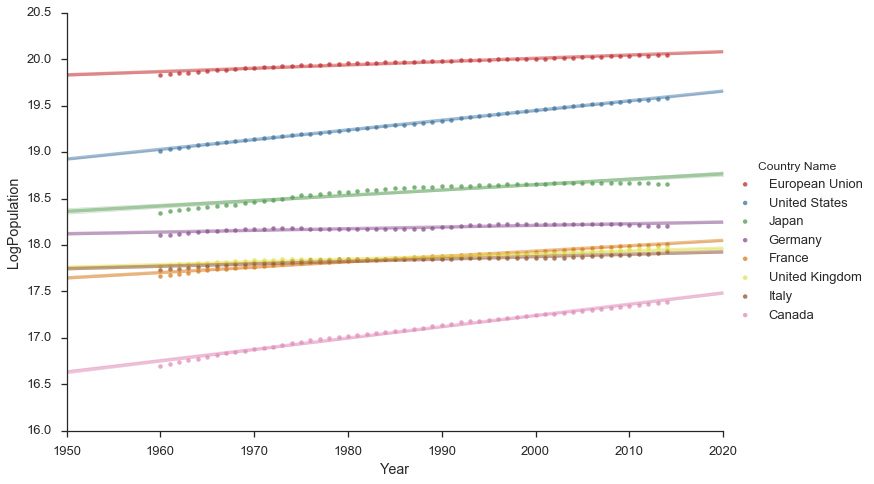

In [17]:
sns.lmplot(
    x='Year', 
    y='LogPopulation', 
    hue='Country Name', 
    data=G8, 
    size=7, 
    aspect=1.5, 
    line_kws={'alpha':0.5}, 
    hue_order=G8_countries
);

This is interesting. While some countries fit very well to the Malthusian model (United States, France, United Kingdom), some countries don't fit as well: Japan seems to have stopped growing during the 1980's, and, European Union, Italy and Canada also seem to decelerate their growth. But this can be due to these countires being "developed". What about some "developing" countries?

## Predictions using linear regression

Let's focus on the four largest countries, only one of the is "developed", but as we saw above it fits the Malthusian model.
We will use _SciPy_'s [`linregress`](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) function to perform linear regression. This will allow us to **extrapolate** - to predict what will be the population of these countries if the rate at which they grow remain constant under the Malthusian model. 

Note that the linear regression of $y$ as a function of $x$ is $y = a x + b$, where $a$ is the slope of the regression and $b$ is the interception. 
But then we have to exponentiate both sides of the equation as we want actual population size and not log population - so we get $e^y = e^{ax+b}$.

Let's extrapolate to the end of the century:

Coefficient of correlation for India: 0.9974, P-value for India: 2.3e-62
Coefficient of correlation for China: 0.9752, P-value for China: 2.2e-36
Coefficient of correlation for United States: 0.9993, P-value for United States: 3.1e-77
Coefficient of correlation for Brazil: 0.9892, P-value for Brazil: 6.6e-46


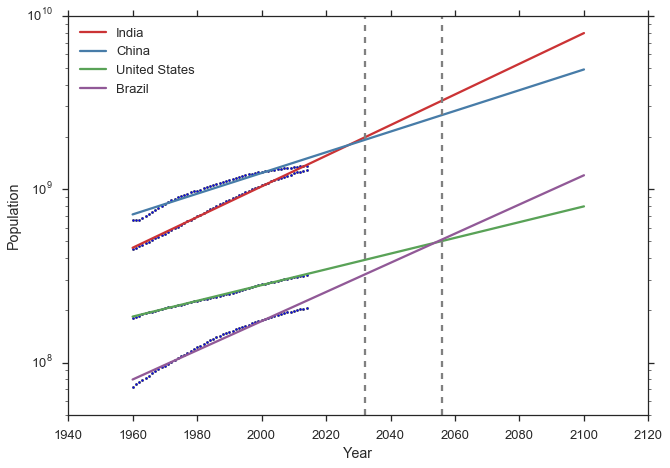

In [18]:
years = np.linspace(df.Year.min(), 2100)
for country_name in ('India','China','United States', 'Brazil'):
    country_df = df[df['Country Name'] == country_name]
    slope, intercept, r_value, p_value, std_err = linregress(country_df.Year, country_df.LogPopulation)
    print("Coefficient of correlation for %s: %.4f" % ( country_name, r_value), end=", ")
    print("P-value for %s: %.2g" % ( country_name, p_value))
    population = np.exp(intercept + slope * years)
    plt.plot(years, population, label=country_name) # prediction
    plt.scatter(country_df.Year, country_df.Population, marker='.', label='') #data
plt.xlabel('Year')
plt.ylabel('Population')
plt.yscale('log')
plt.ylim(5e7,1e10)
plt.legend(loc='upper left')
plt.axvline(x=2032, color='gray', linestyle='--')
plt.axvline(x=2056, color='gray', linestyle='--');

From our prediction, India will pass China around 2032 and Brazil will pass United States around 2056. 

From the results of `linregress` we can estimate confidence intervals on the intercept and slope -- look for it online. We can also [calculate the coefficient of determination](http://stackoverflow.com/a/895063/1063612) ($R^2$).

## Logistic growth model

The Malthusian/exponential growth model can't always be correct: many times growth decelerates and effectively stops when reaching a certain size _K_ (carrying capacity, maximum yield, maximum population density etc.). 
This is true for fish body size (Schnute 1981), microbial population size in a constant volume (Zwietering 1990), and natural animal populations. 
In these cases it is common to use the [**logistic growth model**](http://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth) in which the size of the population inhibits growth, leading to a maximum population size after which growth stops:

$$
\frac{dN}{dt} = r N \Big( 1 - \frac{N}{K} \Big) \Rightarrow \\
N(t) = \frac{K}{1 - \Big( 1 - \frac{K}{N(0)} \Big) e^{-r t} }
$$

Let's start by plotting the logistic function (the second equation).

In [19]:
def logistic(t, N0, K, r):
    return K / (1 - (1 - K/N0) * np.exp(-r * t))

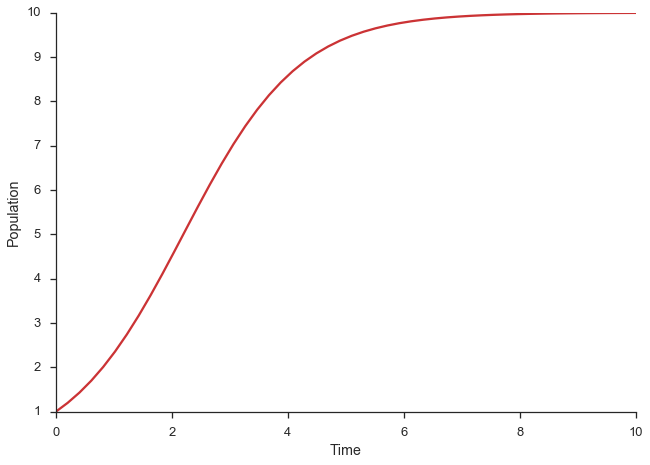

In [20]:
t = np.linspace(0,10)
N = logistic(t, N0=1, K=10, r=1)
plt.plot(t, N)
plt.xlabel('Time')
plt.ylabel('Population')
sns.despine();

## Fitting a logistic model 

So we have a standard growth model, but how do we find the right model (_i.e._ parameters: `N0`, `r`, `K`) for our data? To do this we need to **fit the logistic model** to our data. 

We will use a _SciPy_ function called [`curve_fit`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.curve_fit.html) that accepts a model (a function of `t` and some other arguments/parameters that returns `N`), data (`t` and `N`), initial guesses of the model parameters, and some other optional arguments. It evaluates the model with the initial guesses and calculates the _fit_ of the result -- in standrad fitting this is done by the sum of the square of the differences between the model and the data. It then makes another guess of the model parameters, evaluates the model result and calculates the distance, and again and again. It stops when it reaches a minimal distance, and that's why this operation is called **least squares**. This operation isn't perfect, and when there are even just 3 or 4 model parameters there might be more than one minimum or the function might not find a minimum in a reasonable time.

## Simulated data

Before we try to work with real data we want to [try it with simulated data](http://stackoverflow.com/a/16241965/1063612) and see that we know what we are doing. 
To simulate data we generate data from the logistic function and add some normally distributed noise:

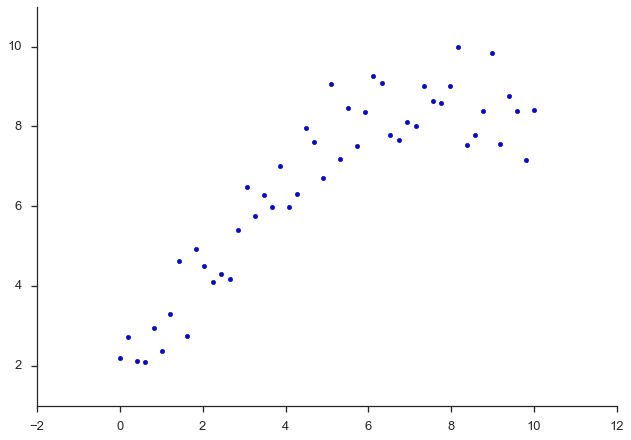

In [21]:
simulated = logistic(t, N0=1.5, K=8.5, r=0.75) +  np.random.normal(loc=0, scale=0.7, size=t.shape)
plt.scatter(t, simulated)
sns.despine()

Now we can call `curve_fit` and give it the simulated data and get back an estimate of the model parameters. As you can see, although there is a lot of noise, we get a pretty good estimate of the parameters.

N0=1.823, K=8.675, r=0.645


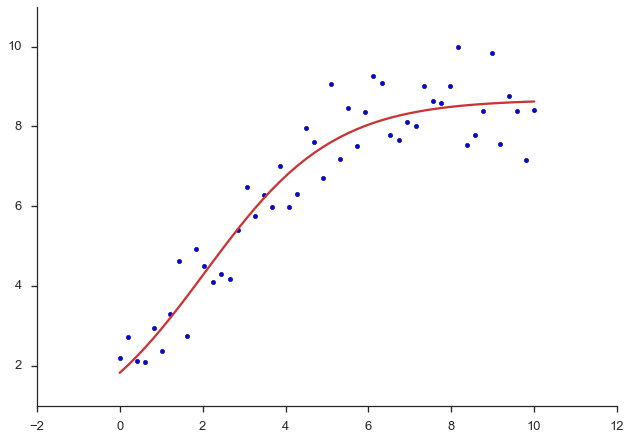

In [22]:
params, cov = curve_fit(f=logistic, xdata=t, ydata=simulated, p0=(1, 10, 1))
N0, K, r = params
plt.scatter(t, simulated)
plt.plot(t, logistic(t, N0, K, r), '-')
sns.despine()
print('N0={0:.3f}, K={1:.3f}, r={2:.3f}'.format(N0, K, r))

We can also get confidence intervals for the parameter values from the `cov` return value. But if you need to work with confidence interals you might prefer to work with the package [lmfit](http://lmfit.github.io/lmfit-py/) which is easier to use if you need more than the basics.

## Real data - bacterial growth curves

We will use growth curves of _E. coli_ bacteria. [This data](https://github.com/Py4Life/TAU2015/blob/master/Yoav_311214c_only_OD.csv) was generated by growing bacteria in a 96-well microtiter plate.

![96-well plate](http://www.ddw-online.com/library/sid32/microplates.jpg)

In [23]:
fname = r'..\data\Yoav_311214c_only_OD.csv'
if not os.path.exists(fname):
    urllib.request.urlretrieve('https://raw.githubusercontent.com/Py4Life/TAU2015/master/Yoav_311214c_only_OD.csv', fname)
df = pd.read_csv(fname)
df.head()

,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H4,H5,H6,H7,H8,H9,H10,H11,H12,Time
0,1,0.0,37.2,0.1128,0.1118,0.1186,0.1213,0.1131,0.1111,0.1178,...,0.1240,0.1352,0.1266,0.1147,0.1157,0.1084,0.1177,0.1217,0.1110,0.000000
1,2,1136.9,37.4,0.1164,0.1151,0.1189,0.1209,0.1173,0.1144,0.1221,...,0.1229,0.1386,0.1289,0.1154,0.1211,0.1103,0.1216,0.1208,0.1130,0.315806
2,3,2273.7,37.3,0.1221,0.1260,0.1242,0.1251,0.1247,0.1222,0.1312,...,0.1350,0.1431,0.1373,0.1219,0.1258,0.1175,0.1276,0.1408,0.1080,0.631583
3,4,3410.5,37.3,0.1315,0.1405,0.1335,0.1338,0.1342,0.1321,0.1469,...,0.1586,0.1493,0.1455,0.1362,0.1349,0.1263,0.1374,0.1777,0.1104,0.947361
4,5,4547.4,36.9,0.1451,0.1464,0.1467,0.1470,0.1486,0.1465,0.1584,...,0.1500,0.1622,0.1593,0.1481,0.1477,0.1385,0.1554,0.1537,0.1089,1.263167


We don't need the `Time [s]` column (we got `Time` in hours) and we don't need `Temp. [°C]`, so we drop these columns.

Then we [melt](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) the data. That means that we transform our data from a matrix format (one row per timepoint, one column per well + columns for other variables such as time) into a data frame format (one row for each measurement, with one column for each measurement variable). 

In [24]:
df = df.drop(axis=1, labels=['Time [s]', 'Temp. [°C]'])
df = pd.melt(df, id_vars=('Time','Cycle Nr.'), var_name='Well', value_name='OD')
df.head()

,Time,Cycle Nr.,Well,OD
0,0.000000,1,A1,0.1128
1,0.315806,2,A1,0.1164
2,0.631583,3,A1,0.1221
3,0.947361,4,A1,0.1315
4,1.263167,5,A1,0.1451


Now let's add a column for the plate row (A - H) and the plate columns (1 - 12). We will use a [list comprehension](http://python-3-patterns-idioms-test.readthedocs.org/en/latest/Comprehensions.html) for that:

In [25]:
def well2row(well):
    return well[0]
def well2col(well):
    return int(well[1:])
df['Row'] = [well2row(x) for x in df.Well]
df['Col'] = [well2col(x) for x in df.Well]
df.head()

,Time,Cycle Nr.,Well,OD,Row,Col
0,0.000000,1,A1,0.1128,A,1
1,0.315806,2,A1,0.1164,A,1
2,0.631583,3,A1,0.1221,A,1
3,0.947361,4,A1,0.1315,A,1
4,1.263167,5,A1,0.1451,A,1


Finally the data is **prepared** and we are ready to explore it.
Let's start by plotting the OD over time curve of every well - just to make sure we know what we have in our hands.

We use `seaborn.FacetGrid` which allows us to easily-ish make faceted plots. We need to specific the DataFrame columns on which we want to facet (these are the `Col` and `Row` we just created) and we can specify a bunch of styling options too. `FacetGrid` will break the data into smaller data sets according to our instructions. We can also specify which column controls the `hue` (color) of the plots.

Then we can `map` a function to each of the facets. We give the function and then the columns that should be used as the function arguments.

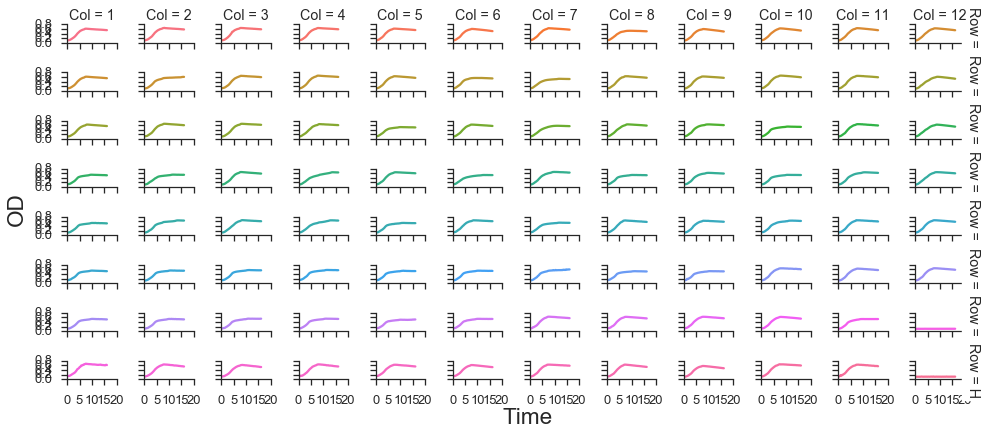

In [26]:
g = sns.FacetGrid(
    data=df, 
    col='Col', 
    row='Row', 
    hue='Well', 
    sharex=True, 
    sharey=True, 
    size=0.75,
    aspect=12./8, 
    despine=True, 
    margin_titles=True
)
g.map(plt.plot, 'Time', 'OD')

plt.locator_params(nbins=4) # 4 ticks is enough
g.set_axis_labels('', '')    # remove facets axis labels
g.fig.text(0.5, 0, 'Time', size='x-large') # xlabel
g.fig.text(-0.01, 0.5, 'OD', size='x-large', rotation='vertical') # ylabel
g.fig.tight_layout()

You might notice that the curves in G12 and H12 are constant - these are the blank/control wells. Let's get rid of them:

In [27]:
df = df[(df.Well != 'G12') & (df.Well != 'H12')]

In order to fit a logistic curve to the data we need to calculate the average curve. This is easy (once you learn how to do it) in _pandas_. The idea is: we _split_ the data by one or more columns. Rows with the same values in these columns will be _grouped_ together. We then _apply_ an aggregation to these groups, meaning we make a single row out of each group. We then _combine_ the rows back together into a single data frame.

This strategy is known as _split-apply_combine_ and it is a very powerful strategy to work with data frames. One of it's powers is that it easily extends to parallel computing because the _apply_ part can be done in parallel over the different groups.

Using [_pandas_](http://pandas.pydata.org/pandas-docs/stable/groupby.html) we will split using the `groupby` method; we will aggregate using `mean` (for general aggregations use `aggregate`); we will then resetthe indices (which were lost during the aggregation) with `reset_index`.

We want the mean OD value for each time point so we group by `Time` and aggregate with `mean`.

In [28]:
grouped = df.groupby('Time')
aggregated = grouped.OD.mean().reset_index()
aggregated.head()

,Time,OD
0,0.000000,0.115427
1,0.315806,0.119079
2,0.631583,0.125883
3,0.947361,0.136205
4,1.263167,0.150218


Let's plot:

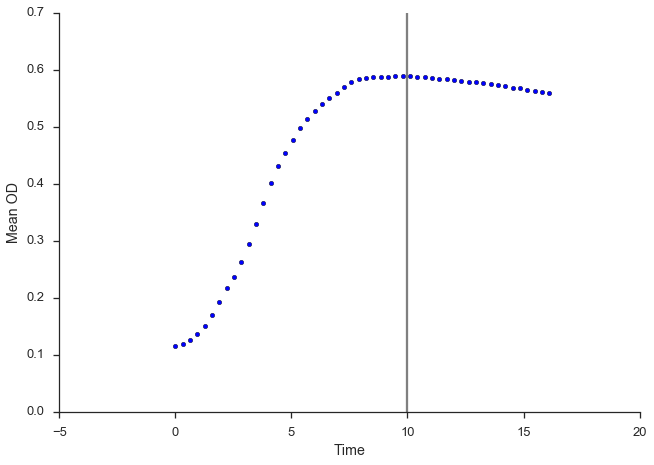

In [29]:
t = aggregated.Time
N = aggregated.OD

plt.scatter(t, N)
plt.xlabel('Time')
plt.ylabel('Mean OD')
plt.axvline(x=10, color='gray')
sns.despine()

You might notice that after about 10 hours the population size starts to decrease. This is an artifact of the experiments, due to the wells starting to dry out. Let's drop this data:

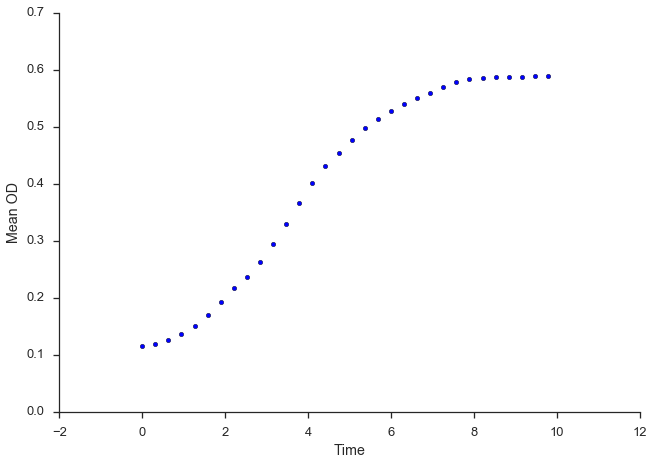

In [30]:
N = N[t<10]
t = t[t<10]

plt.scatter(t, N)
plt.xlabel('Time')
plt.ylabel('Mean OD')
sns.despine()

Now, finally, to the fitting (80% is data preparation!):

N0=0.081, K=0.611, r=0.605392
MSE: 0.000127826579345


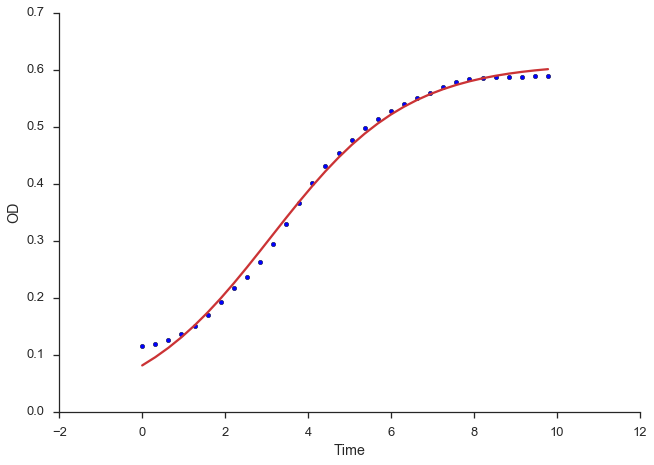

In [43]:
popt, cov = curve_fit(logistic, t, N, (N.min(), N.max(), 1))
N0, K, r = popt
Nhat = logistic(t, N0, K, r)
print('N0={0:.3f}, K={1:.3f}, r={2:.6f}'.format(N0, K, r))
print("MSE:", ((N - Nhat)**2).mean())

plt.scatter(t, N)
plt.plot(t, Nhat)
plt.xlabel('Time')
plt.ylabel('OD')
sns.despine();

## Exercise

Fit the [Gompertz model](https://en.wikipedia.org/wiki/Gompertz_function) to the data:
$$
N(t) = K exp(-T e^{-r T})
$$

where the new parameter $T$ defines the displacement along the x-axis.

Print the MSE and plot the fit and the data. In addition, plot the corresponding logistic curve with the values $N_0, K, r$ estimated for the Gompertz model.

See [Solution code](https://github.com/yoavram/Py4Eng/blob/master/solutions/gompertz-curve-fitting.py).

N0=0.115, K=0.652, r=0.373876, T=2.3090
MSE: 0.000378655558424


D:\Anaconda3\envs\Py4Eng\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


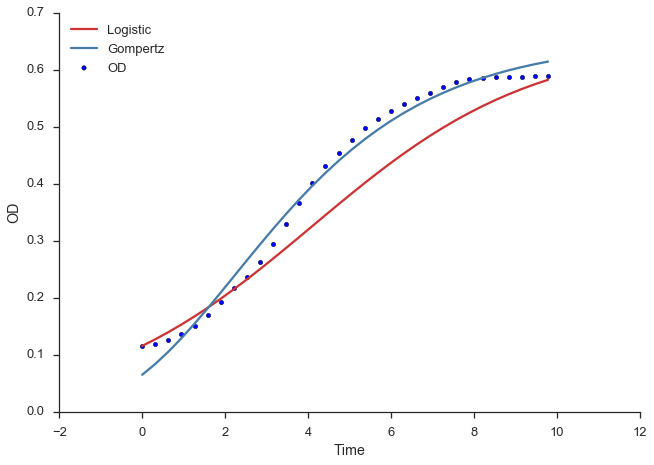

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.0, [IPython](http://ipython.org/) 5.2.2, [Jupyter](http://jupyter.org) 4.3.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)